In [1]:
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pickle


# f2 = open('data/split_0.80_0.10_0.10_aug_to_5000_down_sample_True_instance1/val_data', 'rb')
# f2 = open('data/split_0.80_0.10_0.10_aug_to_5000_down_sample_True_instance1/val_data', 'rb')
# X_sequence_val, X_feature_val, X_image_val, Y_val = pickle.load(f2)
# f2.close()
# f3 = open('data/split_0.80_0.10_0.10_aug_to_5000_down_sample_True_instance1/test_data', 'rb')
f3 = open('data/split_image_0.60_0.30_0.10_aug_to_1875_down_sample_True_instance0-9/test_data', 'rb')
X_sequence_test, X_feature_test, X_image_test, Y_test = pickle.load(f3)
# X_sequence_test, X_feature_test, Y_test = pickle.load(f3)
f3.close()
from keras_preprocessing.sequence import pad_sequences
X_sequence_test_paded = pad_sequences(X_sequence_test, dtype='float', padding='post', value = np.nan)
# X_sequence_val_paded = pad_sequences(X_sequence_val, dtype='float', padding='post', value = np.nan)
from util import preprocess
X_sequence_test_trimed = preprocess(X_sequence_test_paded)
# X_sequence_val_trimed = preprocess(X_sequence_val_paded)

def build_channel(data):
    X = []
    for image in data:
        X.append(image.reshape(128, 128, 1))
    return X
X_image_test = np.array(build_channel(X_image_test))
# X_image_val = np.array(build_channel(X_image_val))
X_feature_test = np.array(X_feature_test)
# X_feature_val = np.array(X_feature_val)
Y_test = np.array(Y_test)-1
# Y_val = np.array(Y_val)-1

2023-02-08 17:33:38.217002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 17:33:38.314774: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [25]:
models = []
best_list_0=[18,8,10,13,10,16,8,16,12,11]
best_list_1=[17,25,16,10,4,25,22,13,21,10]
best_list_2=[11,10,11,7,14,10,16,9,21,11]
best_list_3=[10,26,13,16,15,16,13,12,11,21]
best_acc_list_before_image = [6,5,4,3,5,8,5,4,7,8]
min_loss_list_before_image = [6,6,4,8,7,8,5,6,5,8]
best_acc_list_after_image = [22, 10, 51, 76, 29, 51, 33, 96, 79, 5]
min_loss_list_after_image = [55, 30, 30, 57, 87, 29, 88, 96, 85, 67]
best_acc_list_only_image = [36, 51, 57, 78, 86, 98, 80, 43, 93, 57]
min_loss_list_only_image = [39, 87, 96, 81, 86, 90, 78, 96, 97, 95]
for i in range(0,10):
    # lodaed_model = keras.models.load_model('models/bagging_only_image_0.60_0.30_0.10/cnn_with_feature%d/model_%d'%(i, best_acc_list_only_image[i]),compile=False)
    # lodaed_model = keras.models.load_model('models/bagging_before_image_0.60_0.30_0.10/rnn_with_feature%d/model_%d'%(i,best_acc_list_before_image[i]),compile=False)
    lodaed_model = keras.models.load_model('models/bagging_after_image_0.60_0.30_0.10/mix_model%d/model_%d'%(i,best_acc_list_after_image[i]),compile=False)
    models.append(lodaed_model)

2023-02-08 20:34:35.252577: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-02-08 20:34:36.210229: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-02-08 20:34:36.627084: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2023-02-08 20:34:36.686839: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2023-02-08 20:34:37.488432: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _ou

3/3 [==============================] - 7s 35ms/step
(11, 11)
balanced_acc: 0.7895487612519826
Normalized confusion matrix
[[8.84348497e-01 5.39707016e-03 1.61912105e-02 5.78257517e-02
  1.54202005e-03 7.71010023e-04 6.93909021e-03 0.00000000e+00
  0.00000000e+00 2.69853508e-02 0.00000000e+00]
 [1.77777778e-03 8.93333333e-01 8.53333333e-02 0.00000000e+00
  1.06666667e-02 8.88888889e-04 7.11111111e-03 0.00000000e+00
  8.88888889e-04 0.00000000e+00 0.00000000e+00]
 [4.00000000e-02 2.00000000e-01 7.33333333e-01 2.00000000e-02
  0.00000000e+00 0.00000000e+00 6.66666667e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.70588235e-01 0.00000000e+00 1.76470588e-01 3.33333333e-01
  0.00000000e+00 0.00000000e+00 1.96078431e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.30496454e-03 4.60992908e-03 3.54609929e-04 1.77304965e-04
  8.21276596e-01 4.07801418e-02 1.26595745e-01 7.09219858e-04
  1.24113475e-03 1.24113475e-03 7.09219858e-04]
 [0.00000000e+00 7

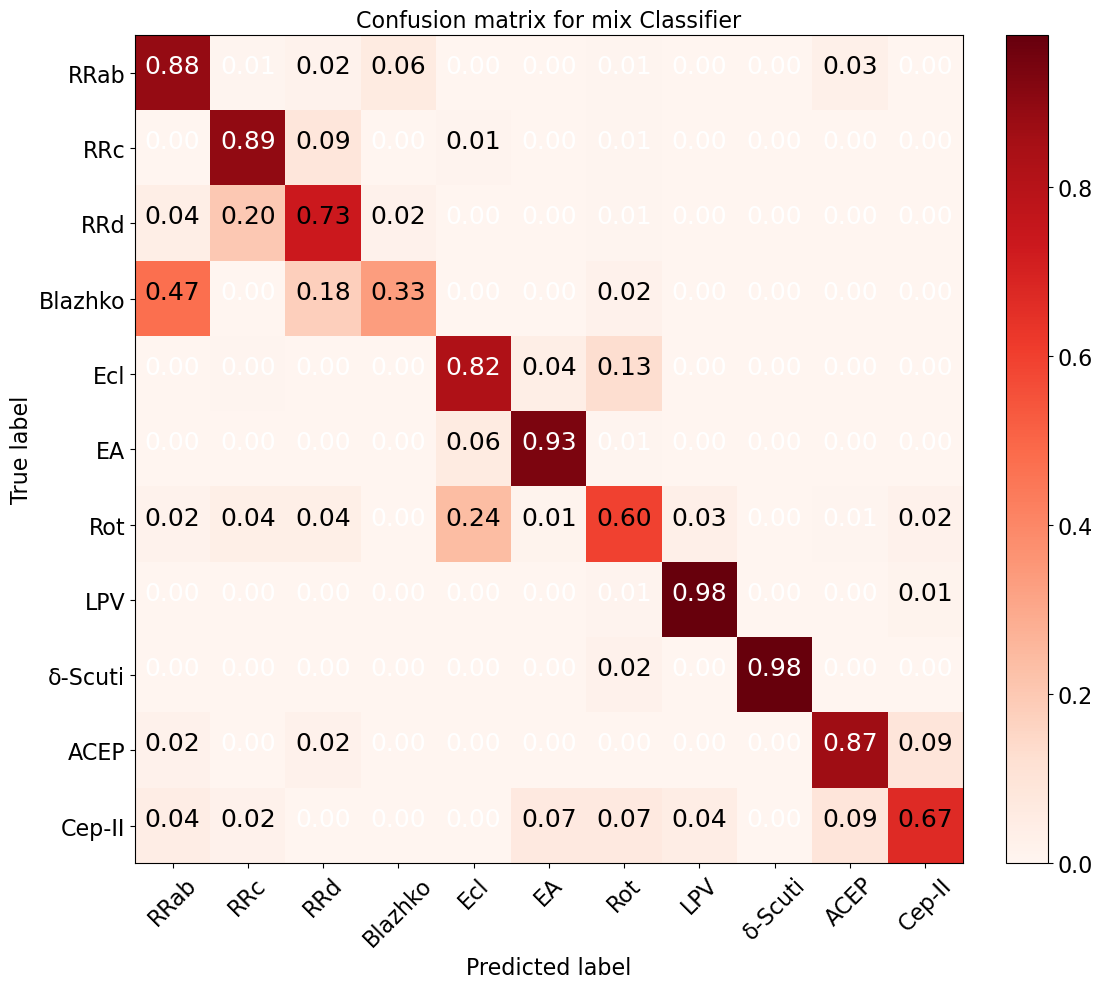

In [35]:

# def generate_batch(X_sequence, X_image,  X_feature, Y, batch_size):
# def generate_batch(X_sequence,  X_feature, Y, batch_size):
#     idx = 0
#     batch_num = len(Y)/batch_size
#     while idx < batch_num:
#         batch_x_sequence = X_sequence[idx * batch_size : (idx + 1) * batch_size]
#         batch_x_feature = X_feature[idx * batch_size : (idx + 1) * batch_size]
#         batch_y = Y[idx * batch_size : (idx + 1) * batch_size]
#         yield batch_x_sequence,  batch_x_feature, batch_y
#         idx += 1
from util import generate_batch
# test_gen = generate_batch(X_sequence_test_trimed, X_image_test, X_feature_test, Y_test, 128)      
test_gen = generate_batch(X_sequence_test_trimed, X_image_test, X_feature_test, Y_test, 128)      

y_label = Y_test

# val_gen = generate_batch(X_sequence_val_trimed, X_image_val, X_feature_val, Y_val, 128)      
# y_label = Y_val


y_predict = np.array([])
for x_sequence, x_image, x_feature, y in test_gen:
# for x_sequence,  x_feature, y in test_gen:
    results = []
    for model in models:
    # for i in (9,):
    #     model = models[i]
        results.append(model.predict({'sequence':x_sequence, 
                                        'image':x_image,
                                        'feature':x_feature}))
    average_result = np.sum(results, axis=0)
    y_predict = np.concatenate([y_predict, np.argmax(average_result, axis=-1)])
y_label = y_label.astype(np.int32) 
y_predict = y_predict.astype(np.int32) 
cm = confusion_matrix(y_true=y_label, y_pred=y_predict, normalize='true')
print(cm.shape)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(values_format='.2g')
balanced_acc = 0
for i in range(0,11):
    balanced_acc += cm[i][i]
balanced_acc = balanced_acc / 11
print('balanced_acc:',balanced_acc)

classes = ['RRab', 'RRc','RRd', 'Blazhko','Ecl', 'EA' , 'Rot', 'LPV','δ-Scuti','ACEP', 'Cep-II']

from util import cm_plot

plotting = cm_plot(cm, classes_types=classes, classifier_model='mix Classifier', nClasses=11,
                    cmap=plt.cm.Blues)

In [5]:
wrong_pre_index = []
right_pre_index = []
for i in range(0,len(y_predict)):
    if y_predict[i] != y_label[i]:
        wrong_pre_index.append(i)
    else:
        right_pre_index.append(i)

In [6]:
splited_wrong_pre_index = [[] for i in range(0,11)]
for index in wrong_pre_index:
    label = y_label[index]
    splited_wrong_pre_index[label].append(index)
splited_right_pre_index = [[] for i in range(0,11)]
for index in right_pre_index:
    label = y_label[index]
    splited_right_pre_index[label].append(index)

In [7]:
for i ,list in enumerate(splited_wrong_pre_index):
    print('%d, length:%d'%(i, len(list)))

0, length:205
1, length:196
2, length:23
3, length:9
4, length:1208
5, length:59
6, length:388
7, length:3
8, length:1
9, length:0
10, length:12


2104
y_label:3
y_predict:0
[0.54263    0.71079141]
period:0.542630,  amplitude:0.710791
1/1 [==============================] - 0s 30ms/step
model result:
[[0.77968234 0.02185127 0.03367399 0.04533277 0.00392207 0.00499551
  0.00470069 0.00438302 0.00156958 0.00676549 0.00221417]]


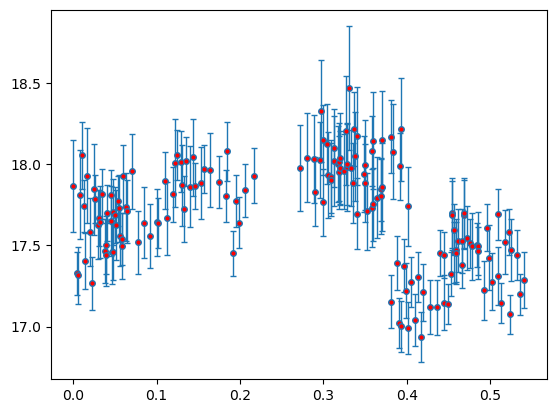

In [12]:

print(len(wrong_pre_index))
index = splited_wrong_pre_index[3][2]
# index = splited_right_pre_index[1][23]
print('y_label:%d'%y_label[index])
print('y_predict:%d'%y_predict[index])
x = X_sequence_test[index][:,0]
y = X_sequence_test[index][:,1]
err = X_sequence_test[index][:,2]
plt.errorbar(x,y,err, fmt='o',ms=4, mfc='r', elinewidth=1, capsize=2)
# plt.imshow(X_image_test[index])
print(X_feature_test[index])
print('period:%f,  amplitude:%f'%(X_feature_test[index][0], X_feature_test[index][1]))

results = []
for model in models:
    results.append(model.predict({'sequence':np.array([X_sequence_test_trimed[index]]), 
                                        'image':np.array([X_image_test[index]]),
                                        'feature':np.array([X_feature_test[index]])}))
average_result = np.sum(results, axis=0) / 11
print('model result:' )
print(average_result)